In [1]:
import tellurium as te

## Basic mouse model


In [101]:
# model from https://academic.oup.com/endo/article/157/2/624/2422698

r = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
// TODO: making this static for now because G_sigmas isn't provided in the paper?
sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is
SI' = (S0 - SI)/tau_SI; // insulin sensitivity

// auxiliary functions
M := G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)); // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;

// sigma calculation
sigma_inf := sigma_ISRinf*sigma_Minf + sigma_b;
sigma_ISRinf := sigma_ISRmax/(1 + sigma_ISRk*exp(-(ISR_sigma - sigma_ISRs)/sigma_ISRs));
sigma_Minf := 1 - sigma_Mmax/(1 + sigma_Mmax*exp(-(M_sigma - sigma_Ms)/sigma_Ms));
M_sigma := (G-G_sigmas)^kM/(alpha_M^kM + (G-G_sigmas)^kM);
ISR_sigma := sigma*(M_sigma + gam)^kISR/(alpha_ISR^kISR + (M_sigma + gam)^kISR);

// parameters
S0 = 0.8;
EG0 = 1.44;
R0 = 864;
V = 0.01;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 10.71;
tau_beta = 42.85;
tau_SI = 16.2;

// auxilliary function parameters (based on zdf rats)
kM = 2;
alpha_M = 150;
kISR = 2;
alpha_ISR = 1.2;
P_max = 4.55;
kP = 4;
alpha_P = 41.77;
A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;
gam_max = 0.2;
gam_s = 99.9;
gam_n = 1;
gam_0 = 0.1;
sigma_ISRmax = 867.6;
sigma_ISRs = 0.1;
sigma_ISRn = 0.1;
sigma_ISRk = 1;
sigma_b = 3;
sigma_Mmax = 1;
sigma_Ms = 0.2;
sigma_Mm = 0.02;
sigma_Mk = 0.2;

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75;

//initial values
G = 99.7664
I = 9.025 
beta = 2.00069  
gam = -0.006666 
sigma = 536.7163 
SI = 0.8

// Events

// variables
G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

// functions
M is "metabolic rate";
ISR is "insulin secretion rate";
P is "beta cell proliferation rate";
A is "beta cell apoptosis rate";

// parameters
R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")

In [102]:
r.resetToOrigin()
result = r.simulate(0, 200, 1000, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])

Traceback (most recent call last):
  File "/tmp/ipykernel_1955/3601440569.py", line 2, in <cell line: 2>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_1955/3601440569.py", line 2, in <cell line: 2>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object


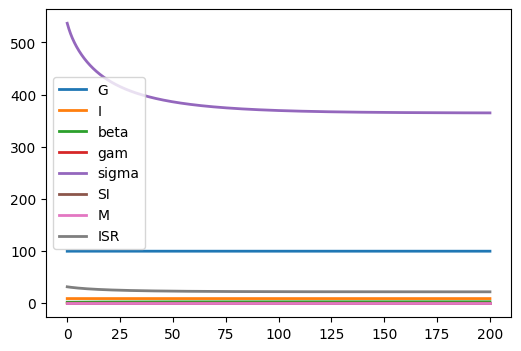

In [103]:
# physiological steady state: beta = 300, G = 100, I = 10
r.plot(result)

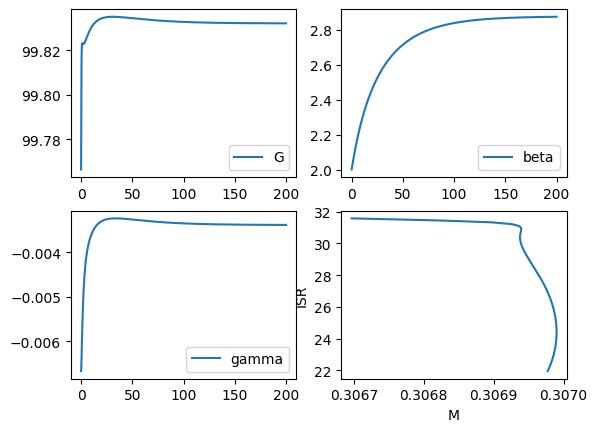

In [104]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.show()

In [105]:
r.resetToOrigin()
r_sigma_fixed = te.loada("""
species $G; species $I; species $beta; species $sigma; species $M; species $ISR;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
// TODO: making this static for now because G_sigmas isn't provided in the paper?
//sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is
SI' = (S0 - SI)/tau_SI; // insulin sensitivity

// auxiliary functions
M := G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)); // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;

// sigma calculation
sigma_inf := sigma_ISRinf*sigma_Minf + sigma_b;
sigma_ISRinf := sigma_ISRmax/(1 + sigma_ISRk*exp(-(ISR_sigma - sigma_ISRs)/sigma_ISRs));
sigma_Minf := 1 - sigma_Mmax/(1 + sigma_Mmax*exp(-(M_sigma - sigma_Ms)/sigma_Ms));
M_sigma := (G-G_sigmas)^kM/(alpha_M^kM + (G-G_sigmas)^kM);
ISR_sigma := sigma*(M_sigma + gam)^kISR/(alpha_ISR^kISR + (M_sigma + gam)^kISR);

// parameters
S0 = 0.8;
EG0 = 1.44;
R0 = 864;
V = 0.01;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 10.71;
tau_beta = 42.85;
tau_SI = 16.2;

// auxilliary function parameters (based on zdf rats)
kM = 2;
alpha_M = 150;
kISR = 2;
alpha_ISR = 1.2;
P_max = 4.55;
kP = 4;
alpha_P = 41.77;
A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;
gam_max = 0.2;
gam_s = 99.9;
gam_n = 1;
gam_0 = 0.1;
sigma_ISRmax = 867.6;
sigma_ISRs = 0.1;
sigma_ISRn = 0.1;
sigma_ISRk = 1;
sigma_b = 3;
sigma_Mmax = 1;
sigma_Ms = 0.2;
sigma_Mm = 0.02;
sigma_Mk = 0.2;

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75;

//initial values
G = 99.7664
I = 9.025 
beta = 2.00069  
gam = -0.006666 
sigma = 536.7163 
SI = 0.8

// Events

// variables
G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

// functions
M is "metabolic rate";
ISR is "insulin secretion rate";
P is "beta cell proliferation rate";
A is "beta cell apoptosis rate";

// parameters
R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")
r_sigma_fixed.setValue('SI', 0.4)
r_sigma_fixed.setValue('S0', 0.4)
result = r_sigma_fixed.simulate(0, 100, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])

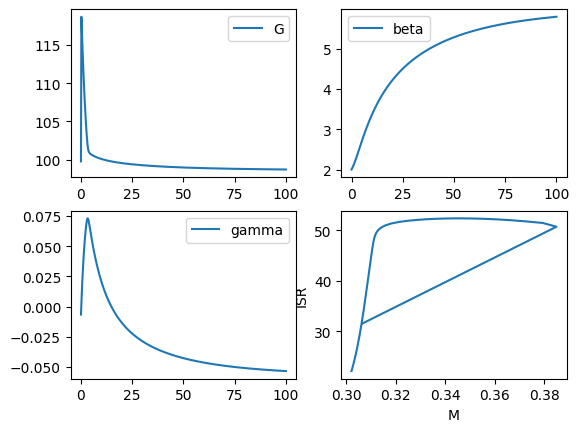

In [106]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.show()

Traceback (most recent call last):
  File "/tmp/ipykernel_1955/1490226172.py", line 4, in <cell line: 4>
RuntimeError: Object of type <class 'NamedArray'> appears to be C subclassed NumPy array, void scalar, or allocated in a non-standard way.NumPy reserves the right to change the size of these structures. Projects are required to take this into account by either recompiling against a specific NumPy version or padding the struct and enforcing a maximum NumPy version.
Exception ignored in: 'PyDataMem_UserFREE'
Traceback (most recent call last):
  File "/tmp/ipykernel_1955/1490226172.py", line 4, in <cell line: 4>
ValueError: PyCapsule_GetPointer called with invalid PyCapsule object


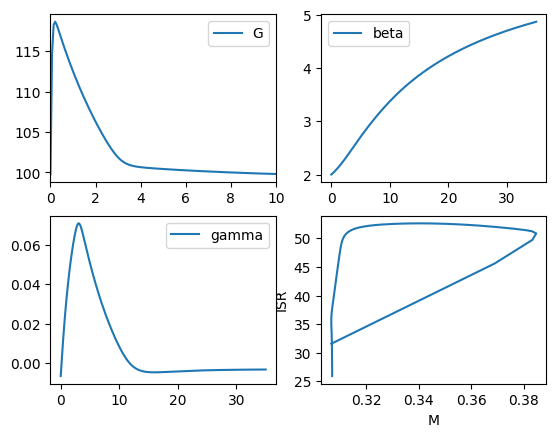

In [109]:
r.resetToOrigin()
r.setValue('SI', 0.4)
r.setValue('S0', 0.4)
result = r.simulate(0, 35, 500, selections=['time', 'G', 'I', 'beta', 'gam', 'sigma', 'SI', 'M', 'ISR'])
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(result['time'], result['G'], label='G')
axes[0, 0].set_xlim(0, 10)
axes[0, 0].legend()
axes[0, 1].plot(result['time'], result['beta'], label='beta')
axes[0, 1].legend()
axes[1, 0].plot(result['time'], result['gam'], label='gamma')
axes[1, 0].legend()
axes[1, 1].plot(result['M'], result['ISR'])
axes[1, 1].set_xlabel('M')
axes[1, 1].set_ylabel('ISR')
fig.show()

## Mouse model code from github

Source: https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/ZDF.ode

## Human model

Source: https://github.com/artielbm/artielbm.github.io/blob/master/Models/Pathogenesis/human.ode

In [29]:
# model from https://academic.oup.com/endo/article/157/2/624/2422698

r_human = te.loada("""
species $G; species $I; species $beta;

//rates
G' = R0 - (EG0 + SI*I)*G; // glucose concentration in blood (mg/dL)
I' = beta*ISR/V - k*I; // insulin concentration in blood
beta' = ((P - A)*beta)/tau_beta; // beta cell mass - based on workload hypothesis
// functional compensation - persistent high glucose shifts the glucose response curve to the left
gam' = (gam_inf - gam)/tau_gam;
// persistent high glucose increases maximal insulin concentration
// TODO: making this static for now because G_sigmas isn't provided in the paper?
sigma' = (sigma_inf - sigma)/tau_sigma; //sigma is
SI' = (S0 - SI)/tau_SI; // insulin sensitivity

// auxiliary functions
M := G^kM/(alpha_M^kM + G^kM); // beta cell metabolism
ISR := sigma*(M + gam)^kISR/(alpha_ISR^kISR + (M + gam)^kISR); // insulin secretion rate

P := P_max*(ISR^kP/(alpha_P^kP + ISR^kP)); // beta cell proliferation
A := A_max*(M^kA/(alpha_A^kA + M^kA)); // beta cell apoptosis

gam_inf := gam_max/(1 + exp(-(G - gam_s)/gam_n)) - gam_0;

// sigma calculation
sigma_inf := sigma_ISRinf*sigma_Minf + sigma_b;
sigma_ISRinf := sigma_ISRmax/(1 + sigma_ISRk*exp(-(ISR_sigma - sigma_ISRs)/sigma_ISRs));
sigma_Minf := 1 - sigma_Mmax/(1 + sigma_Mmax*exp(-(M_sigma - sigma_Ms)/sigma_Ms));
M_sigma := (G-G_sigmas)^kM/(alpha_M^kM + (G-G_sigmas)^kM);
ISR_sigma := sigma*(M_sigma + gam)^kISR/(alpha_ISR^kISR + (M_sigma + gam)^kISR);

// parameters
S0 = 0.72;
EG0 = 1.44;
R0 = 864;
V = 5;
k = 700;

// time scales (in days)
tau_gam = 2.14;
tau_sigma = 249.9;
tau_beta = 8570;
tau_SI = 16.2;

// auxilliary function parameters (based on zdf rats)
kM = 2;
alpha_M = 150;
kISR = 2;
alpha_ISR = 1.2;
P_max = 4.55;
kP = 4;
alpha_P = 41.77;
A_max = 3.11;
kA = 6;
alpha_A = 0.44;
A_b = 0.8;
gam_max = 0.2;
gam_s = 99.9;
gam_n = 1;
gam_0 = 0.1;
sigma_ISRmax = 867.6;
sigma_ISRs = 0.1;
sigma_ISRn = 0.1;
sigma_ISRk = 1;
sigma_b = 3;
sigma_Mmax = 1;
sigma_Ms = 0.2;
sigma_Mm = 0.02;
sigma_Mk = 0.2;

// this value isn't provided in the paper, but it is in the code (as sigma_Gsh).
G_sigmas := 75;


//initial values
G = 99.7664
I = 9.025 
beta = 1000.423   
gam = -0.006666 
sigma = 536.67 
SI = 0.8

G is "plasma glucose concentration (mg/dL)";
I is "plasma insulin concentration (microU/mL)";
beta is "beta cell mass (mg)";
gam is "dose response curve shift";
sigma is "beta cell function (microU/(microg*d))";
SI is "insulin sensitivity (mL/(microU*d))";

R0 is "average daily glucose production rate";
EG0 is "insulin-independent glucose disposal rate";
S0 is "initial insulin sensitivity";
V is "volume of distribution";
k is "insulin clearance rate";
""")

In [30]:
# long-term equilibrium?
result = r_human.simulate(0, 50000, 50000)

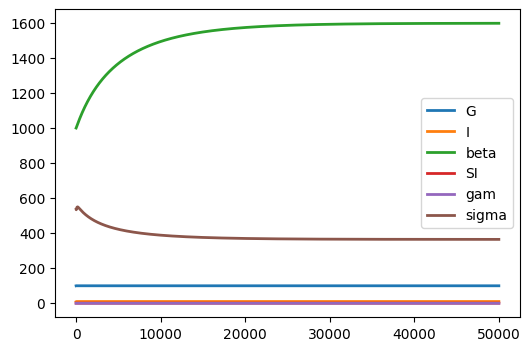

In [31]:
r_human.plot(result)

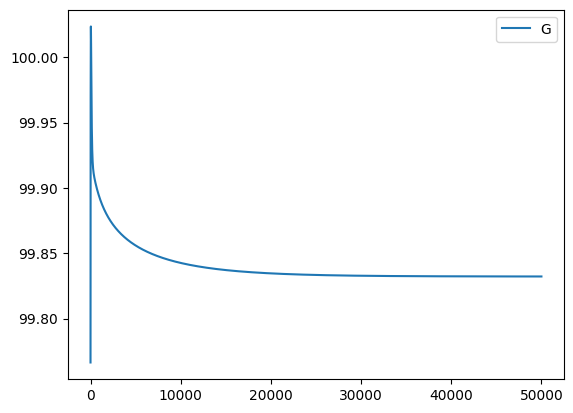

In [32]:
plt.plot(result['time'], result['G'])
plt.legend('G')